In [67]:
import json
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tifffile
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, Normalize, RandomCrop, Compose
from einops import rearrange
from kmeans_pytorch import kmeans

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [33]:
import multiplex_imaging_pipeline.utils as utils
from vit_pytorch import ViT, MAE
from vit_pytorch.slide_mae import SlideMAE, SlideMAEV2


## input data

In [5]:
metadata = json.load(open('../data/test_registration/HT397B1_v2/registered/metadata.json'))
metadata

{'downsample_scaler': 0.1,
 'phenocycler_pixels_per_micron': 1.9604911906033102,
 'order': ['HT397B1-S1H3A1U1',
  'HT397B1-S1H3A1U2',
  'HT397B1-S1H3A1U12',
  'HT397B1-S1H3A1U21',
  'HT397B1-S1H3A1U22',
  'HT397B1-S1H3A1U31'],
 'data_type': ['visium', 'codex', 'codex', 'visium', 'codex', 'codex'],
 'slices': ['s0', 's1', 's2', 's3', 's4', 's5']}

In [6]:
fps = sorted(utils.listfiles('/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered',
                     regex='ome.tiff$'))
fps

['/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s1.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s2.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s4.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s5.ome.tiff']

In [7]:
pool = []
for fp in fps:
    channels = utils.get_ome_tiff_channels(fp)
    channels = [utils.R_CHANNEL_MAPPING.get(c, c) for c in channels]
    pool += channels
Counter(pool).most_common()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


[('Bap1', 4),
 ('CD31', 4),
 ('CD45', 4),
 ('CD68', 4),
 ('CD8', 4),
 ('CK19', 4),
 ('COX6c', 4),
 ('DAPI', 4),
 ('ER', 4),
 ('FOXP3', 4),
 ('GATA3', 4),
 ('GLUT1', 4),
 ('HLA-DR', 4),
 ('Her2', 4),
 ('CK14', 4),
 ('Ki67', 4),
 ('MGP', 4),
 ('PLAT/tPA', 4),
 ('PR', 4),
 ('Pan-Cytokeratin', 4),
 ('Podoplanin', 4),
 ('SMA', 4),
 ('Vimentin', 4),
 ('cKit', 4),
 ('CD20', 2),
 ('CD3e', 2),
 ('CD11b', 1),
 ('E-cadherin', 1)]

In [8]:
channels = sorted([c for c, count in Counter(pool).items() if count==len(fps)])
channels

['Bap1',
 'CD31',
 'CD45',
 'CD68',
 'CD8',
 'CK14',
 'CK19',
 'COX6c',
 'DAPI',
 'ER',
 'FOXP3',
 'GATA3',
 'GLUT1',
 'HLA-DR',
 'Her2',
 'Ki67',
 'MGP',
 'PLAT/tPA',
 'PR',
 'Pan-Cytokeratin',
 'Podoplanin',
 'SMA',
 'Vimentin',
 'cKit']

In [9]:
scale = .1
slide_to_img = {}
for fp in fps:
    sample = fp.split('/')[-1].replace('.ome.tiff', '')
    cs, img = utils.extract_ome_tiff(fp, as_dict=False)
    img = torch.tensor(img)
    thumbnail = TF.resize(img, (int(scale * img.shape[-2]), int(scale * img.shape[-1])))
    thumbnail = thumbnail.to(torch.float32)
    
    cs = [utils.R_CHANNEL_MAPPING[c] for c in cs]
    idxs = [cs.index(c) for c in channels]
    thumbnail = thumbnail[idxs]
    
    slide_to_img[sample] = thumbnail

In [10]:
thumbnail = next(iter(slide_to_img.values()))

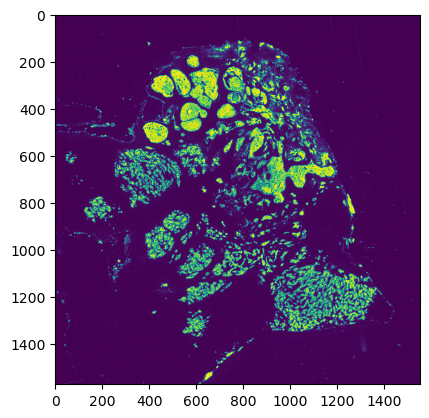

In [11]:
plt.imshow(thumbnail[channels.index('Pan-Cytokeratin')])

In [55]:
class MAETransform(object):
    def __init__(self, size=(256, 256), normalize=None):
        self.transforms = Compose([
            RandomCrop(size, padding_mode='reflect'),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            normalize if normalize is not None else nn.Identity()
        ])

    def __call__(self, x):
        return self.transforms(x)
    
class InferenceTransform(object):
    def __init__(self, normalize=None):
        self.transforms = Compose([
            normalize if normalize is not None else nn.Identity()
        ])

    def __call__(self, x):
        return self.transforms(x)
    
class MatchedSlideDataset(Dataset):
    def __init__(self, slide_to_img, transform=None):
        self.slides = sorted(slide_to_img.keys())
        self.stacked_slides = torch.stack([slide_to_img[s] for s in self.slides])

        self.transform = transform if transform is not None else nn.Identity()

    def __len__(self):
        return np.iinfo(np.int64).max # make infinite

    def __getitem__(self, idx):
        slide1_idx = np.random.choice(len(self.slides) - 1)
        slide2_idx = slide1_idx + 1
        
        return {
            'slide1_idx': slide1_idx,
            'slide2_idx': slide2_idx,
            'img': transform(self.stacked_slides[slide1_idx:slide2_idx + 1])
        }

class InferenceSlideDataset(Dataset):
    def __init__(self, slide_to_img, size=(256, 256), transform=None):
        """"""
        self.size = size
        self.slides = sorted(slide_to_img.keys())
        self.slide_to_img = slide_to_img
        
        # tiles are (ph pw c h w)
        self.slide_to_tiles = {s:self.to_tiles(x) for s, x in self.slide_to_img.items()}
        self.pw, self.ph = self.slide_to_tiles[self.slides[0]].shape[:2]
        
        self.n_tiles_per_image = self.pw * self.ph
        outs = torch.stack(torch.meshgrid(
            torch.arange(len(self.slides)),
            torch.arange(self.slide_to_tiles[self.slides[0]].shape[0]),
            torch.arange(self.slide_to_tiles[self.slides[0]].shape[1])
        ))
        self.idx_to_coord = rearrange(
            outs, 'b n_slides n_rows n_cols -> (n_slides n_rows n_cols) b',
            n_slides=len(self.slides), n_rows=self.ph, n_cols=self.pw, b=3)


        self.transform = transform if transform is not None else nn.Identity()
        
    def to_tiles(self, x, size=None):
        size = self.size if size is None else size
        pad_h, pad_w = size[-2] - x.shape[-2] % size[-2], size[-1] - x.shape[-1] % size[-1]
        # left, top, right and bottom
        x = TF.pad(x, [pad_w // 2, pad_h // 2, pad_w // 2 + pad_w % 2, pad_h // 2 + pad_h % 2])
        x = x.unfold(-2, size[-2], size[-2] // 2)
        x = x.unfold(-2, size[-1], size[-1] // 2)
        x = rearrange(x, 'c ph pw h w -> ph pw c h w')
        return x

    def image_from_tiles(self, x):
        pad_h, pad_w = x.shape[-2] // 4, x.shape[-1] // 4
        x = x[..., pad_h:-pad_h, pad_w:-pad_w]
        return rearrange(x, 'ph pw c h w -> c (ph h) (pw w)')
    
    def slide_from_tiles(self, x, slide_idx, size=None):
        """
        x - (n c h w)
        """
        size = self.size if size is None else size
        mask = self.idx_to_coord[:, 0]==slide_idx
        tiles = x[mask]
        ph, pw = self.idx_to_coord[mask, 1].max() + 1, self.idx_to_coord[mask, 2].max() + 1
        
        out = torch.zeros(ph, pw, x.shape[1], size[0], size[1])
        for idx, (_, r, c) in enumerate(self.idx_to_coord[mask]):
            out[r, c] = tiles[idx]
        
        return self.image_from_tiles(out)

    def __len__(self):
        return self.idx_to_coord.shape[0]

    def __getitem__(self, idx):
        slide_idx, row_idx, col_idx = self.idx_to_coord[idx]
        slide = self.slides[slide_idx]
        return {
            'slide_idx': slide_idx,
            'row_idx': row_idx,
            'col_idx': col_idx,
            'img': transform(self.slide_to_tiles[slide][row_idx, col_idx])
        }

In [26]:
means = torch.cat([x.mean(dim=(-2, -1)).unsqueeze(0) for x in slide_to_img.values()]).mean(0)
stds = torch.cat([x.std(dim=(-2, -1)).unsqueeze(0) for x in slide_to_img.values()]).mean(0)
means, stds

(tensor([ 0.0801,  1.0852,  1.9242,  0.1526,  0.4242,  1.5283,  6.9707,  0.4142,
         10.0162,  3.5788,  0.2126, 11.7128,  5.6175,  6.0933,  0.1766,  1.1214,
          4.9701,  2.3110,  6.1405, 19.0076,  0.4349,  4.8628, 21.0575,  0.6115]),
 tensor([ 0.8096,  6.8269,  4.6411,  0.6164,  2.7208, 11.1956, 24.7025,  1.5357,
         13.1523, 10.1505,  1.7475, 36.9418, 14.6443, 21.0886,  0.8051, 10.7819,
          9.9388,  5.4503, 13.5437, 52.9554,  1.8941, 21.8240, 44.8913,  1.7298]))

In [56]:
size = (256, 256)

normalize = Normalize(means, stds)
transform = InferenceTransform(normalize=normalize)
inference_ds = InferenceSlideDataset(slide_to_img, transform=transform)

In [40]:
inference_dl = DataLoader(inference_ds, batch_size=32, shuffle=False)

In [31]:
v = ViT(
    image_size = size[0],
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    channels=len(channels),
)

In [34]:
mae = SlideMAEV2(
    encoder = v,
    n_slides = len(slide_to_img),
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 6       # anywhere from 1 to 8
)

In [35]:
mae.load_state_dict(torch.load('../data/mae_v4/46000iter.pt'))

<All keys matched successfully>

In [36]:
mae.eval()

SlideMAEV2(
  (encoder): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
      (1): LayerNorm((24576,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=24576, out_features=1024, bias=True)
      (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (transformer): Transformer(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (attend): Softmax(dim=-1)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_qkv): Linear(in_features=1024, out_features=1536, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=1024, bias=True)
                (1): Dropout(p=0.0, inplace=False)
              )
            )
          )
          (1

In [41]:
all_encoded_tokens = torch.zeros(len(inference_ds), size[0] // 32, size[1] // 32, v.pos_embedding.shape[-1])
all_decoded_tokens = torch.zeros(len(inference_ds), size[0] // 32, size[1] // 32, mae.decoder_dim)
all_pred_patches = torch.zeros(len(inference_ds), len(channels), size[0], size[1])
bs = inference_dl.batch_size
with torch.no_grad():
    for i, b in enumerate(inference_dl):
        x, slide_idx = b['img'], b['slide_idx']
        if v.pos_embedding.is_cuda:
            x, slide_idx = x.to(v.pos_embedding.device), slide_idx.to(v.pos_embedding.device)
        
        encoded_tokens = mae.encode(x, slide_idx)
        decoded_tokens = mae.decode(encoded_tokens)
        pred_pixel_values = mae.to_pixels(decoded_tokens[:, 1:])

        encoded_tokens = rearrange(encoded_tokens[:, 1:], 'b (h w) d -> b h w d',
                                  h=size[0] // 32, w=size[1] // 32)
        decoded_tokens = rearrange(decoded_tokens[:, 1:], 'b (h w) d -> b h w d',
                                  h=size[0] // 32, w=size[1] // 32)
        pred_patches = rearrange(
            pred_pixel_values, 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
            h=size[0] // 32, w=size[0] // 32, p1=32, p2=32, c=len(channels))
        
        all_encoded_tokens[i * bs:(i + 1) * bs] = encoded_tokens.cpu().detach()
        all_decoded_tokens[i * bs:(i + 1) * bs] = decoded_tokens.cpu().detach()
        all_pred_patches[i * bs:(i + 1) * bs] = pred_patches.cpu().detach()

In [42]:
all_encoded_tokens.shape, all_decoded_tokens.shape, all_pred_patches.shape

(torch.Size([676, 8, 8, 1024]),
 torch.Size([676, 8, 8, 512]),
 torch.Size([676, 24, 256, 256]))

In [57]:
x = inference_ds.slide_from_tiles(all_pred_patches, 0)
x.shape

torch.Size([24, 1664, 1664])

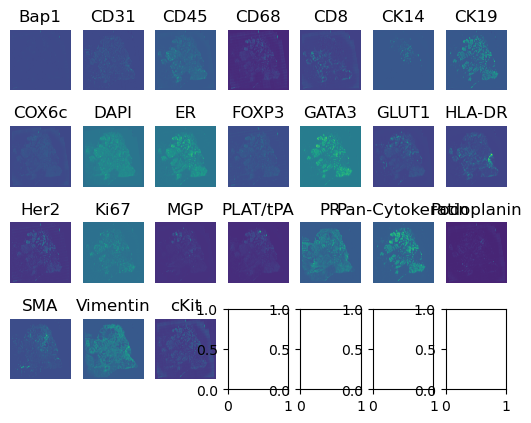

In [58]:
n_cols = 7
n_rows = len(channels) // n_cols + 1
rc = [(i, j) for i in range(n_rows) for j in range(n_cols)]

fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows)
rc = [(i, j) for i in range(n_rows) for j in range(n_cols)]
for (row_idx, col_idx), c in zip(rc, channels):
    ax = axs[row_idx, col_idx]
    ax.imshow(x[channels.index(c)])
    ax.axis('off')
    ax.set_title(c)

In [45]:
all_encoded_tokens.shape

torch.Size([676, 8, 8, 1024])

In [49]:
num_clusters = 20
x = rearrange(all_encoded_tokens, 'n h w d -> (n h w) d')
cluster_ids, cluster_centers = kmeans(
    X=x, num_clusters=num_clusters, distance='euclidean', device=torch.device('cuda:1'), tol=10.,
)

running k-means on cuda:1..




[running kmeans]: 0it [00:00, ?it/s]

[running kmeans]: 0it [00:01, ?it/s, center_shift=392163.062500, iteration=1, tol=10.000000]

[running kmeans]: 1it [00:01,  1.04s/it, center_shift=392163.062500, iteration=1, tol=10.000000]

[running kmeans]: 1it [00:02,  1.04s/it, center_shift=18035.048828, iteration=2, tol=10.000000] 

[running kmeans]: 2it [00:02,  1.01s/it, center_shift=18035.048828, iteration=2, tol=10.000000]

[running kmeans]: 2it [00:03,  1.01s/it, center_shift=3147.759766, iteration=3, tol=10.000000] 

[running kmeans]: 3it [00:03,  1.01s/it, center_shift=3147.759766, iteration=3, tol=10.000000]

[running kmeans]: 3it [00:04,  1.01s/it, center_shift=505.438629, iteration=4, tol=10.000000] 

[running kmeans]: 4it [00:04,  1.00s/it, center_shift=505.438629, iteration=4, tol=10.000000]

[running kmeans]: 4it [00:05,  1.00s/it, center_shift=220.739838, iteration=5, tol=10.000000]

[running kmeans]: 5it [00:05,  1.00s/it, center_shift=220.739838, iteration=5, tol=10.000000]


In [52]:
cluster_ids, cluster_centers = cluster_ids.cpu().detach(), cluster_centers.cpu().detach()

In [53]:
cluster_ids.shape, cluster_centers.shape

(torch.Size([43264]), torch.Size([20, 1024]))

In [59]:
cluster_imgs = rearrange(cluster_ids, '(n h w) -> n 1 h w',
                        n=all_encoded_tokens.shape[0], h=all_encoded_tokens.shape[1], w=all_encoded_tokens.shape[2])
cluster_imgs.shape

torch.Size([676, 1, 8, 8])

In [73]:
labeled_img = inference_ds.slide_from_tiles(
    cluster_imgs, 0, size=(cluster_imgs.shape[-2], cluster_imgs.shape[-1])).squeeze().to(torch.long)
labeled_img.shape

torch.Size([52, 52])

In [74]:
# plt.imshow(labeled_img[0])

In [77]:
def display_labeled_as_rgb(labeled, cmap=None):
    if isinstance(labeled, torch.Tensor):
        labeled = labeled.numpy()
    cmap = sns.color_palette() if cmap is None else cmap
    labels = sorted(np.unique(labeled))
    if len(cmap) < len(labels):
        raise RuntimeError('cmap is too small')
    new = np.zeros((labeled.shape[0], labeled.shape[1], 3))
    for l in labels:
        c = cmap[l]
        new[labeled==l] = c
    return new

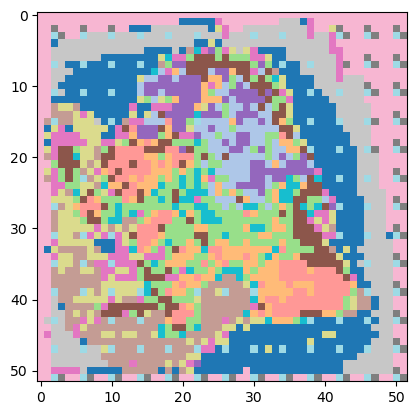

In [78]:
plt.imshow(display_labeled_as_rgb(labeled_img, cmap=sns.color_palette('tab20')))

In [81]:
stacked_labeled = []
for i in range(len(slide_to_img)):
    stacked_labeled.append(inference_ds.slide_from_tiles(
        cluster_imgs, i, size=(cluster_imgs.shape[-2], cluster_imgs.shape[-1])).squeeze().to(torch.long))
stacked_labeled = torch.stack(stacked_labeled)
stacked_labeled.shape

torch.Size([4, 52, 52])

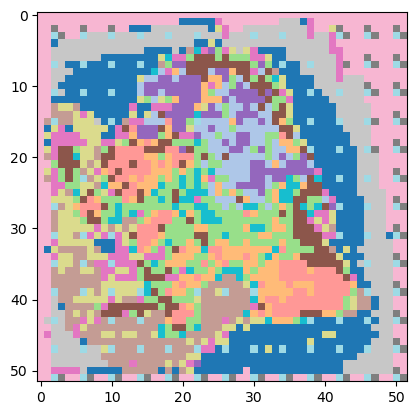

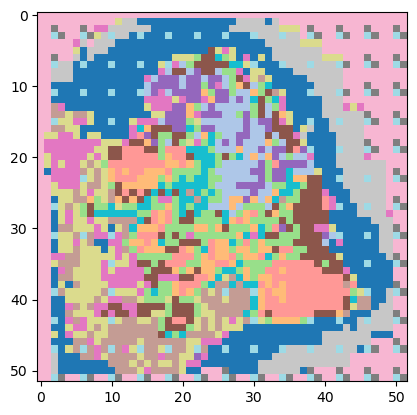

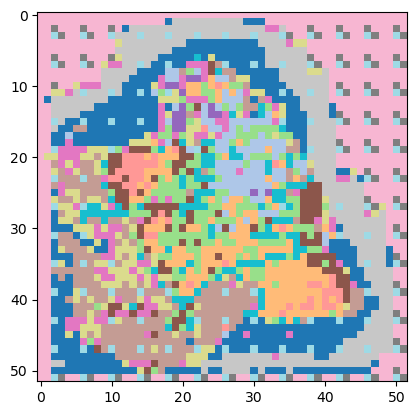

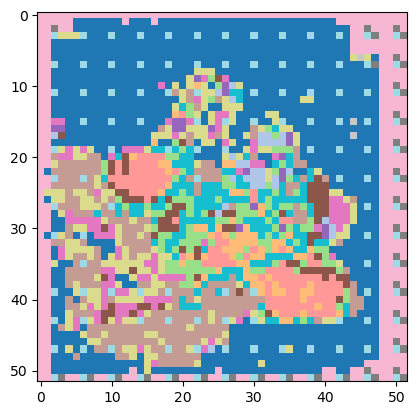

In [82]:
cmap = sns.color_palette('tab20')
for i, labeled in enumerate(stacked_labeled):
    plt.imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    plt.show()